In [1]:
import numpy as np
import matplotlib.pylab as plt

/Users/vincent/Development/notebooks/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  if __name__ == '__main__':


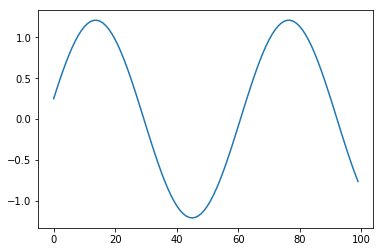

In [2]:
k = 100
mu = np.zeros(k)
sigma = np.eye(k)

for i in range(k):
    for j in range(k):
        sigma[i, j] = np.sin(i/10 - j/10)

plt.plot(np.random.multivariate_normal(mu, sigma));

# Why does it show this? 

It is a bit strange, our gaussian is showing repeating patterns. Why is that? 

![](kernel.png)

We have a function that can convert distances to a covariance matrix. Whatever function we pick essentially determines when we have high covariance between numbers.

![](cov.png)

In the image above $\Sigma_{\text{repeat}}$ is generated with a pattern that allows for high correlation between items that are a certain period apart while the $\Sigma_{\text{rbf}}$ assigns high correlation between items that are close to eachother.

# But you can combine these kernels! 

Let's get [cooking](http://www.cs.toronto.edu/~duvenaud/cookbook/index.html).

In [3]:
from operator import mul, add

class Kernel:
    def __init__(self, func, name=None, **kwargs):
        self.name = func.__name__ if not name else name
        self.func = func
        self.kwargs = kwargs 
        
    def __call__(self, xi, xj):
        return self.func(xi, xj, **self.kwargs)
    
    def _operate(self, other, op):
        operator_str = '+' if op == add else '*'
        name = '(' + self.name + operator_str + other.name + ')'
        def wrapper(xi, xj):
            return op(self(xi, xj), other(xi, xj))
        return Kernel(func=wrapper, name=name)
    
    def __add__(self, other):
        return self._operate(other, add) 
    
    def __mul__(self, other):
        return self._operate(other, mul) 
    
    def __repr__(self):
        return self.name
    
    def sample(self, k=100):
        mu = np.zeros(k)
        sigma = np.eye(k)
        for i in range(k):
            for j in range(k):
                sigma[i, j] = self(i, j)
        return np.random.multivariate_normal(mu, sigma)


In [4]:
import warnings 
warnings.filterwarnings('ignore')

def rbf(xi, xj, param=1):
    return np.exp(-param*(xi/10 - xj/10)**2)

def repeat(xi, xj, param=1):
    return np.sin(param*(xi/10 - xj/10))

def const(xi, xj, param=1):
    return param

def linear(xi, xj):
    return xi/10 - xj/10

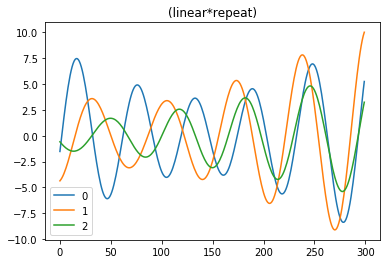

In [5]:
kern = Kernel(linear) * Kernel(repeat)

for param in range(3):
    plt.plot(kern.sample(300), label=param)
plt.title(kern)
plt.legend();

In [6]:
k = 25

mu = np.zeros(k)
sigma = np.eye(k)
for i in range(k):
    for j in range(k):
        sigma[i, j] = np.abs(np.sin(i/10 - j/10))
sigma[:2]

array([[0.        , 0.09983342, 0.19866933, 0.29552021, 0.38941834,
        0.47942554, 0.56464247, 0.64421769, 0.71735609, 0.78332691,
        0.84147098, 0.89120736, 0.93203909, 0.96355819, 0.98544973,
        0.99749499, 0.9995736 , 0.99166481, 0.97384763, 0.94630009,
        0.90929743, 0.86320937, 0.8084964 , 0.74570521, 0.67546318],
       [0.09983342, 0.        , 0.09983342, 0.19866933, 0.29552021,
        0.38941834, 0.47942554, 0.56464247, 0.64421769, 0.71735609,
        0.78332691, 0.84147098, 0.89120736, 0.93203909, 0.96355819,
        0.98544973, 0.99749499, 0.9995736 , 0.99166481, 0.97384763,
        0.94630009, 0.90929743, 0.86320937, 0.8084964 , 0.74570521]])

# But how will we fit data? 

The high dimensional Gaussian has a cool property.

![](inferance.png)

The "alternative view" is similar.

![](timestuff.png)

# Why does that work?

Everything we do is determined by the covariance matrix. 

![](timestuff2.png)

There's a bunch of math that you need for this. I've listed it here but I will ignore it in order to move on to the demo of it working.

#### The Maths 

Suppose you'd like to calculate $p(x_1 | x_2 = a)$. 

$$
\begin{aligned} \boldsymbol{\mu} &=\left[\begin{array}{c}{\boldsymbol{\mu}_{1}} \\ {\boldsymbol{\mu}_{2}}\end{array}\right] \text { with sizes }\left[\begin{array}{c}{q \times 1} \\ {(N-q) \times 1}\end{array}\right] \\ \boldsymbol{\Sigma} &=\left[\begin{array}{cc}{\boldsymbol{\Sigma}_{11}} & {\boldsymbol{\Sigma}_{12}} \\ {\boldsymbol{\Sigma}_{21}} & {\boldsymbol{\Sigma}_{22}}\end{array}\right] \text { with sizes }\left[\begin{array}{cc}{q \times q} & {q \times(N-q)} \\ {(N-q) \times q} & {(N-q) \times(N-q)}\end{array}\right] \end{aligned}
$$

Then this is the most likely timeseries line: 

$$
\overline{\boldsymbol{\mu}}=\boldsymbol{\mu}_{1}+\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1}\left(\mathbf{a}-\boldsymbol{\mu}_{2}\right)
$$

In [7]:
def rbf(xi, xj, param=1):
    return np.exp(-param*(xi - xj)**2)

def repeat(xi, xj, param=1):
    return np.sin(param*(xi - xj))

def const(xi, xj, param=1):
    return param

def linear(xi, xj):
    return xi - xj

def fit_predict(kernel, known_x, known_y, xs, noise=0.1):
    known_x, known_y = np.array(known_x), np.array(known_y)
    K12 = np.zeros(shape=(xs.shape[0], known_x.shape[0]))
    for i, x_i in enumerate(xs):
        for j, x_j in enumerate(known_x): 
            K12[i, j] = kernel(x_i/10, x_j/10)
    K21 = K12.T

    K22 = np.zeros(shape=(known_x.shape[0], known_x.shape[0]))
    for i, x_i in enumerate(known_x):
        for j, x_j in enumerate(known_x): 
            K22[i, j] = kernel(x_i/10, x_j/10)

    K11 = np.zeros(shape=(xs.shape[0], xs.shape[0]))
    for i, x_i in enumerate(xs):
        for j, x_j in enumerate(xs): 
            K11[i, j] = kernel(x_i/10, x_j/10)

    mu = K12 @ np.linalg.inv(K22 + noise * np.eye(known_x.shape[0])) @ known_y.T
    return mu

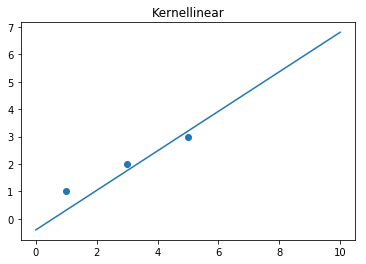

In [8]:
kern = Kernel(linear)

x_in = [1,3,5]
y_in = [1,2,3]

preds = fit_predict(kern, 
                    known_x=x_in, 
                    known_y=y_in, 
                    xs=np.linspace(0, 10, 100))

plt.plot(np.linspace(0, 10, 100), preds)
plt.scatter(x_in, y_in)
plt.title('Kernel' + str(kern));